# Algoritmo MWPCA (Moving Window Principal Component Analysis)

Este notebook implementa o algoritmo MWPCA para detecção de falhas em sistemas usando análise de componentes principais com janela deslizante.

## Importar Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Configuração dos Parâmetros

Defina aqui o caminho do arquivo CSV e o tamanho da janela deslizante:
- **csv_path**: Caminho para o arquivo de dados
- **window_length**: Tamanho da janela deslizante (número de linhas)

In [2]:

# --- Configuration ---
csv_path   = "dados/dados.csv"   # <-- set your file path, e.g. "/path/to/data.xlsx"
window_length = 15               # moving window length (rows)


## Carregamento e Preparação dos Dados

Este código realiza as seguintes etapas:

1. **Carregamento do CSV**: Tenta diferentes codificações (UTF-8, Latin-1, CP1252, ISO-8859-1) para lidar com caracteres especiais
2. **Transposição**: Transpõe o DataFrame para que os nomes das linhas se tornem cabeçalhos de colunas e os dados se tornem linhas
3. **Limpeza**: Remove espaços em branco dos nomes das linhas
4. **Conversão numérica**: Converte todos os dados para float, tratando valores não numéricos como NaN




In [3]:
df = pd.read_csv(csv_path)

df = df.astype(float)

# Filter Cluster 
df = df[df["Cluster"] == 3].drop(columns=["Cluster", "Amostra"])





In [4]:
df

,S1,S2,S3,S4
200,19.965,30.543,39.980,50.455
201,19.537,30.002,40.418,50.246
202,20.554,29.970,40.106,49.338
203,19.701,30.264,39.895,50.320
204,20.062,30.293,39.849,49.762
...,...,...,...,...
295,22.675,32.754,41.601,51.523
296,23.010,31.892,42.036,51.795
297,22.874,32.652,41.940,51.518
298,23.226,32.425,42.150,51.019


## Seleção de Variáveis

O código seleciona automaticamente as variáveis (colunas) a serem utilizadas:
- Primeiro tenta encontrar colunas que começam com 'Var'
- Se não encontrar, seleciona as últimas 6 colunas numéricas (ou todas se houver menos de 3)
- Converte os dados selecionados para uma matriz numpy `X_all`

In [5]:


# auto-detect columns starting with 'Var'
auto_cols = [c for c in df.columns if str(c).startswith('Var')]
if not auto_cols:
    # fallback: pick the last 6 numeric columns
    num_cols = df.select_dtypes(include=[float,int]).columns.tolist()
    auto_cols = num_cols[-6:] if len(num_cols) >= 3 else num_cols
var_columns = auto_cols

print("Using variable columns:", var_columns)

X_all = df[var_columns].to_numpy(dtype=float)



Using variable columns: ['S1', 'S2', 'S3', 'S4']


In [6]:
def calculate_parameter_means(matrix):
    return np.mean(matrix, axis=0)

def subtract_means(matrix):
    means = calculate_parameter_means(matrix)
    return matrix - means


def calculate_covariance_matrix(matrix):
    centered = subtract_means(matrix)
    cov_matrix = np.cov(centered, rowvar=False)
    return cov_matrix


def calculate_pca(matrix):
    m = matrix.shape[1] // 2  # Only original dimensions count

    cov_matrix = calculate_covariance_matrix(matrix)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals_sorted = eigvals[sorted_indices]


    # Normalize eigenvalues to percentages
    eigvals_percent = eigvals_sorted / np.sum(eigvals_sorted[:m]) * 100

    # If eigvals_percent has length 2, add a third element with value 0
    if len(eigvals_percent) == 2:
        eigvals_percent = np.append(eigvals_percent, 0)

    return eigvals_percent

## Definição da Janela de Referência

A janela de referência (`ref`) é definida como as primeiras `window_length` linhas dos dados. Esta janela representa o estado normal/operacional do sistema e será usada como base de comparação para todas as janelas subsequentes.

In [7]:
ref = X_all[0:window_length]

PCA function 

In [8]:
rows = []


for start in range(0, window_length):
    end =  start  + window_length   # exclusive
    Xw = X_all[start: end]
    Z = np.hstack([ref, Xw])  


    pcws = calculate_pca(Z)

    
    rows.append({
        "window_start": start,
        "window_end":   end,
        "W_PC1": pcws[0],
        "W_PC2": pcws[1],
        "W_PC3": pcws[2]

    })

In [9]:
rows = pd.DataFrame(rows)

### Cálculo dos Limites Estatísticos

A partir dos pesos calculados nas janelas iniciais, determinamos os limites de controle usando a regra dos 3-sigma (99.7% dos dados normais estão dentro deste intervalo).

In [10]:
PCW = ["W_PC1","W_PC2","W_PC3"]

# Per-PC stats (each column separately)
mu_w = rows[PCW].mean(axis=0)             # mean per PC
sd_w = rows[PCW].std(ddof=1, axis=0)      # sample std per PC
LCL_w = mu_w - 3*sd_w 
UCL_w = mu_w + 3*sd_w

### Visualização dos Limites

Verifique os valores de LCL (Lower Control Limit) e UCL (Upper Control Limit) calculados:

In [11]:
LCL_w

W_PC1    28.702616
W_PC2    17.738736
W_PC3    10.832564
dtype: float64

In [12]:
UCL_w

W_PC1    53.965991
W_PC2    37.493790
W_PC3    26.127473
dtype: float64

In [13]:
def calculate_parameter_means(matrix):
    return np.mean(matrix, axis=0)

def subtract_means(matrix):
    means = calculate_parameter_means(matrix)
    return matrix - means


def calculate_covariance_matrix(matrix):
    centered = subtract_means(matrix)
    cov_matrix = np.cov(centered, rowvar=False)
    return cov_matrix


def calculate_pca(matrix):
    m = matrix.shape[1] // 2  # Only original dimensions count

    cov_matrix = calculate_covariance_matrix(matrix)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals_sorted = eigvals[sorted_indices]


    # Normalize eigenvalues to percentages
    eigvals_percent = eigvals_sorted / np.sum(eigvals_sorted[:m]) * 100

    # If eigvals_percent has length 2, add a third element with value 0
    if len(eigvals_percent) == 2:
        eigvals_percent = np.append(eigvals_percent, 0)

    return eigvals_percent







In [14]:
# --- Sliding-window MWPCA ---
results = []


for start in range(window_length+1, len(X_all)-window_length+1):
    end = start + window_length  # exclusive
    Xw = X_all[start: end]
    Z = np.hstack([ref, Xw])  


    pcws = calculate_pca(Z)

    
    results.append({
        "window_start": start,
        "window_end":   end,
        "W_PC1": pcws[0],
        "W_PC2": pcws[1],
        "W_PC3": pcws[2]

    })

In [15]:
results = pd.DataFrame(results)
results

,window_start,window_end,W_PC1,W_PC2,W_PC3
0,16,31,37.586166,28.522973,22.276591
1,17,32,36.167822,29.014116,20.523761
2,18,33,36.878686,27.605319,23.037415
3,19,34,32.239067,28.163846,22.098654
4,20,35,45.303224,23.442899,18.464512
...,...,...,...,...,...
65,81,96,42.519332,25.346621,21.047665
66,82,97,38.503368,25.140263,22.834020
67,83,98,36.754002,24.553061,21.424619
68,84,99,30.500961,26.889642,24.574647


In [16]:
ref = X_all[0:window_length]

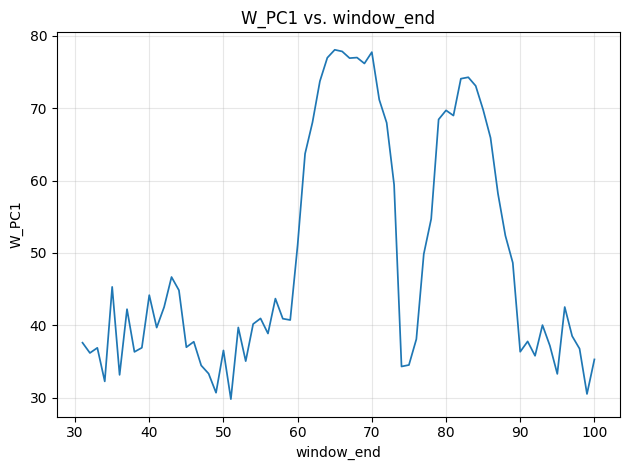

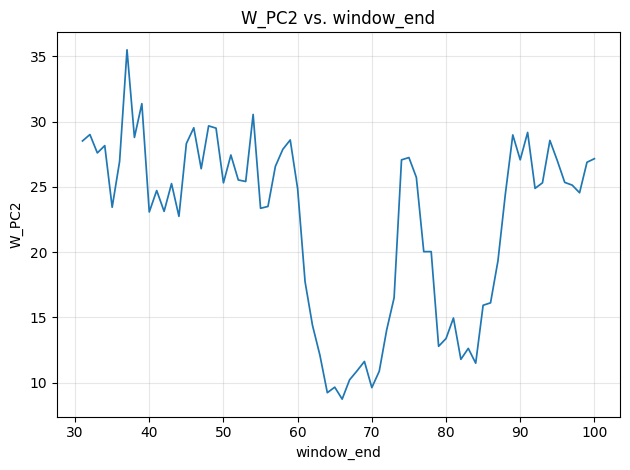

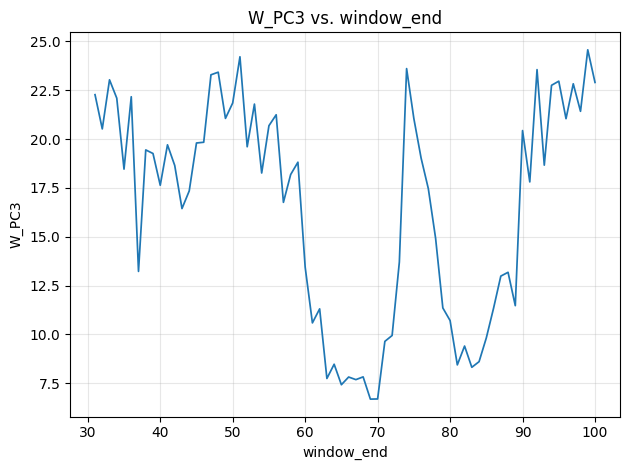

In [17]:
# Ensure ordered by start; drop rows with missing values in the needed columns
cols = ["window_end", "W_PC1", "W_PC2", "W_PC3"]
dfp = (results[cols]
       .dropna(subset=cols)
       .sort_values("window_end")
       .reset_index(drop=True))

x = dfp["window_end"].to_numpy()


for pc_col in ["W_PC1", "W_PC2", "W_PC3"]:
    plt.figure()
    plt.plot(x, dfp[pc_col].to_numpy(), linewidth=1.25)
    plt.xlabel("window_end")
    plt.ylabel(pc_col)
    plt.title(f"{pc_col} vs. window_end")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Gráfico Combinado dos Componentes Principais

Este gráfico mostra todos os três componentes principais juntos para facilitar a comparação.

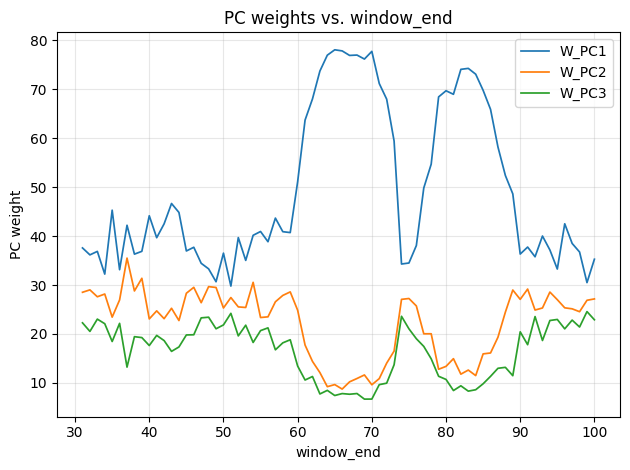

In [18]:
# Sort by start and keep needed columns
cols = ["window_end", "W_PC1", "W_PC2", "W_PC3"]
dfp = (results[cols]
       .dropna(subset=cols)
       .sort_values("window_end")
       .reset_index(drop=True))

x = dfp["window_end"].to_numpy()


plt.figure()
plt.plot(x, dfp["W_PC1"].to_numpy(), label="W_PC1", linewidth=1.25)
plt.plot(x, dfp["W_PC2"].to_numpy(), label="W_PC2", linewidth=1.25)
plt.plot(x, dfp["W_PC3"].to_numpy(), label="W_PC3", linewidth=1.25)
plt.xlabel("window_end")
plt.ylabel("PC weight")
plt.title("PC weights vs. window_end")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Detecção de Anomalias

Nesta seção, identificamos janelas onde os pesos dos componentes principais estão fora dos limites de controle:

1. **Detecção por componente**: Para cada PC (W_PC1, W_PC2, W_PC3), verificamos se está abaixo de LCL ou acima de UCL
2. **Detecção combinada**: 
   - **Det_ge2**: Indica se 2 ou mais componentes estão fora dos limites (critério mais rigoroso)
   - **Det_any**: Indica se pelo menos 1 componente está fora dos limites (critério mais sensível)
3. **Exportação**: Os resultados são salvos em `result.csv` para análise posterior

In [19]:
# columns we care about
PCW = ["W_PC1", "W_PC2", "W_PC3"]

# ensure LCL_w / UCL_w are aligned Series indexed by PC column names
# (from your earlier cells they already are)
#LCL = LCL_w[PCW]
#UCL = UCL_w[PCW]

df = results.copy()

flags = (df[PCW].lt(LCL_w)) | (df[PCW].gt(UCL_w))
flags = flags.rename(columns={"W_PC1":"Det_PC1","W_PC2":"Det_PC2","W_PC3":"Det_PC3"})
pc_cols = ["Det_PC1","Det_PC2","Det_PC3"]

flags["Det_ge2"] = flags[pc_cols].sum(axis=1) >= 2   # compute first, on PCs only
flags["Det_any"] = flags[pc_cols].any(axis=1)

# Build an output DataFrame showing sample id and detections
out_cols = ["window_start", "window_end"] if {"window_start","window_end"}.issubset(df.columns) else []
result = pd.concat([df[out_cols], df[PCW], flags], axis=1)

display(result.head())
print("Rows:", len(result))
print("Counts per PC (True = out of limits):")
print(flags[["Det_PC1","Det_PC2","Det_PC3"]].sum())
print("Rows with ≥2 PCs out of limits:", int(flags["Det_ge2"].sum()))
result.to_csv("result.csv")

,window_start,window_end,W_PC1,W_PC2,W_PC3,Det_PC1,Det_PC2,Det_PC3,Det_ge2,Det_any
0,16,31,37.586166,28.522973,22.276591,False,False,False,False,False
1,17,32,36.167822,29.014116,20.523761,False,False,False,False,False
2,18,33,36.878686,27.605319,23.037415,False,False,False,False,False
3,19,34,32.239067,28.163846,22.098654,False,False,False,False,False
4,20,35,45.303224,23.442899,18.464512,False,False,False,False,False


Rows: 70
Counts per PC (True = out of limits):
Det_PC1    23
Det_PC2    21
Det_PC3    17
dtype: int64
Rows with ≥2 PCs out of limits: 21


### Visualização da Detecção de Anomalias

Este gráfico mostra quando o critério **Det_ge2** (2 ou mais componentes fora dos limites) é ativado ao longo do tempo. O gráfico em degrau facilita a visualização dos períodos de detecção.

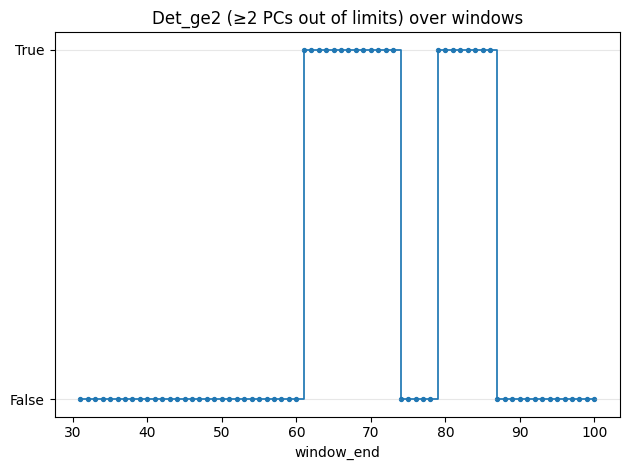

In [20]:
# Use your existing result (or merge df and flags so we have window_start + Det_ge2)
dfp = (result[["window_end", "Det_ge2"]]
       .dropna()
       .sort_values("window_end")
       .reset_index(drop=True))

# Map booleans to 0/1 for plotting
y = dfp["Det_ge2"].astype(int).to_numpy()
x = dfp["window_end"].to_numpy()


plt.figure()
# Step line to show on/off runs clearly
plt.step(x, y, where="post", linewidth=1.25)
# Markers on each window (optional)
plt.scatter(x, y, s=8)

plt.yticks([0, 1], ["False", "True"])
plt.xlabel("window_end")
plt.title("Det_ge2 (≥2 PCs out of limits) over windows")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()